In [395]:
import matplotlib.pyplot as plt
import torch
import time



In [396]:
ln_in = torch.load("ln_1_input.pt")
ln_out = torch.load("ln_1_output.pt")
ln_weight = torch.load("ln_1_weight.pt")
ln_bias = torch.load("ln_1_bias.pt")
ln_eps = torch.load("ln_1_eps.pt")
print(ln_in.shape)
print(ln_out.shape)
print(ln_weight.shape)
print(ln_bias.shape)
print(ln_eps)

torch.Size([128, 197, 768])
torch.Size([128, 197, 768])
torch.Size([768])
torch.Size([768])
1e-06


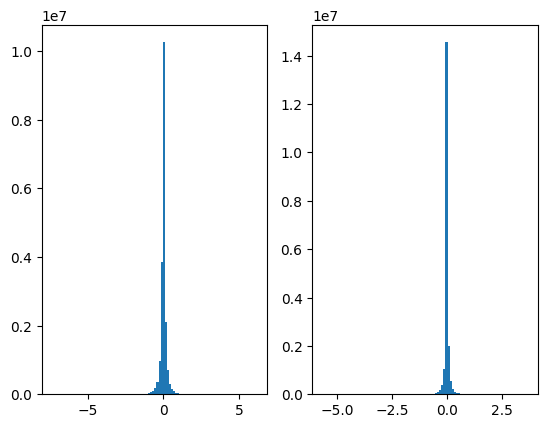

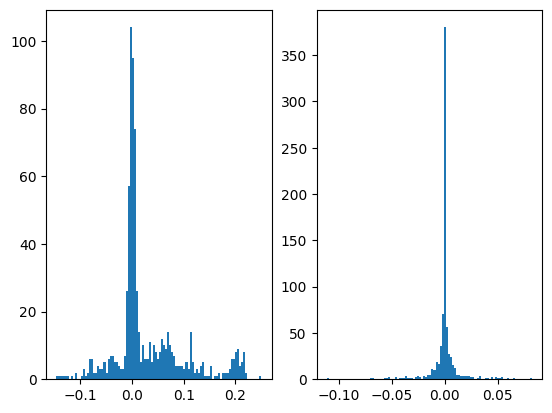

In [397]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(ln_in.flatten().cpu().numpy(), bins=100)
ax[1].hist(ln_out.flatten().cpu().numpy(), bins=100)
plt.show()
fig, ax = plt.subplots(1, 2)
ax[0].hist(ln_weight.flatten().cpu().numpy(), bins=100)
ax[1].hist(ln_bias.flatten().cpu().numpy(), bins=100)
plt.show()

In [398]:
def int_SQRT(n):
    if n == 0:
        return 0
    else:
        _bit_len = torch.tensor(int(n).bit_length())
        x = 2 ** (torch.ceil(_bit_len / 2))
        while True:
            x_next = torch.floor((x + torch.floor(n / x)) / 2)

            if x_next >= x:
                return x.item()  # Return as a Python integer
            else:
                x = x_next


# Create a tensor of shape (12, 197, 768)
x_q = torch.randint(0, 255, (12, 197, 10))  # Example values, scaled for larger integers


# Function to apply int_SQRT to each element in a tensor
def apply_int_SQRT_to_tensor(tensor):
    shape = tensor.shape
    tensor = tensor.flatten()  # Flatten the tensor to 1D for easier iteration
    result = torch.tensor([int_SQRT(val) for val in tensor], dtype=torch.int32)
    return result.view(shape)  # Reshape the result back to the original shape


# Apply the function
starttime = time.time()
result = apply_int_SQRT_to_tensor(x_q)
print("algorithm Time taken: ", time.time() - starttime, "s")


starttime = time.time()
org = x_q.sqrt().floor()
print("torch sqrt Time taken: ", time.time() - starttime, "s")

# print(result.shape)  # Should print torch.Size([12, 197, 768])

print(torch.norm(result - org))

algorithm Time taken:  1.2985548973083496 s
torch sqrt Time taken:  0.010291576385498047 s
tensor(0.)


In [399]:
def int_SQRT(n):
    if n == 0:
        return 0
    else:
        _bit_len = torch.tensor(int(n).bit_length())
        x = 2 ** (torch.ceil(_bit_len / 2))
        while True:
            x_next = torch.floor((x + torch.floor(n / x)) / 2)

            if x_next >= x:
                return x.item()  # Return as a Python integer
            else:
                x = x_next


# Function to apply int_SQRT to each element in a tensor
def apply_int_SQRT_to_tensor(tensor):
    shape = tensor.shape
    tensor = tensor.flatten()  # Flatten the tensor to 1D for easier iteration
    result = torch.tensor([int_SQRT(val) for val in tensor], dtype=torch.int32)
    return result.view(shape)  # Reshape the result back to the original shape


def int_LayerNorm(x_q, s_x, weight, bias, eps):

    mean_q = x_q.mean(dim=-1, keepdim=True).round()
    var_q = x_q.var(dim=-1, keepdim=True, unbiased=False).round()

    weight_q = (weight / s_x).round()
    bias_q = (bias / s_x).round()
    eps_q = (eps / s_x).round()

    assert var_q.min() >= 0, "Negative variance detected"
    assert eps_q.min() >= 0, "Negative epsilon detected"
    div_by = apply_int_SQRT_to_tensor(var_q + eps_q)
    div_by[div_by == 0] = 1  # Avoid division by zero
    
    y_q = (x_q - mean_q) / div_by * weight_q + bias_q

    return y_q, s_x

tensor(-5.6708, device='cuda:0') tensor(3.6660, device='cuda:0')
tensor(-5.6960, device='cuda:0') tensor(3.6680, device='cuda:0')
tensor(0.6522, device='cuda:0')


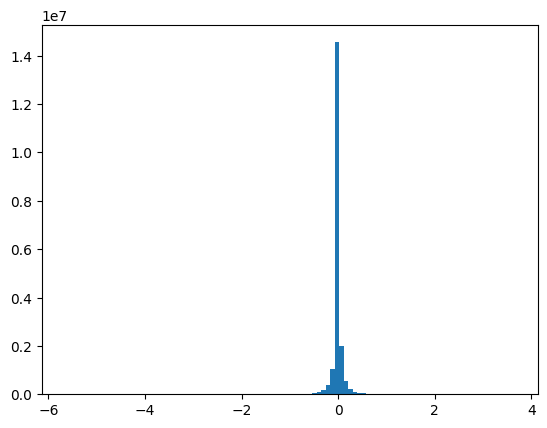

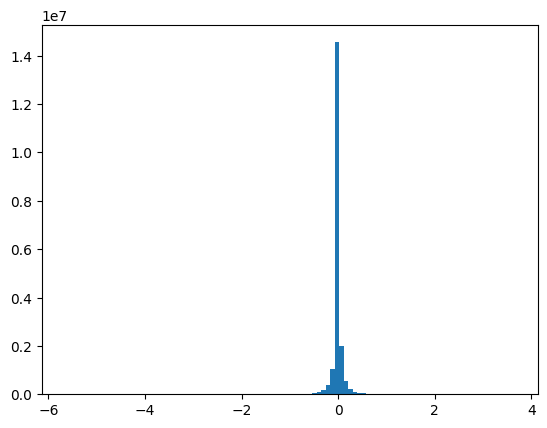

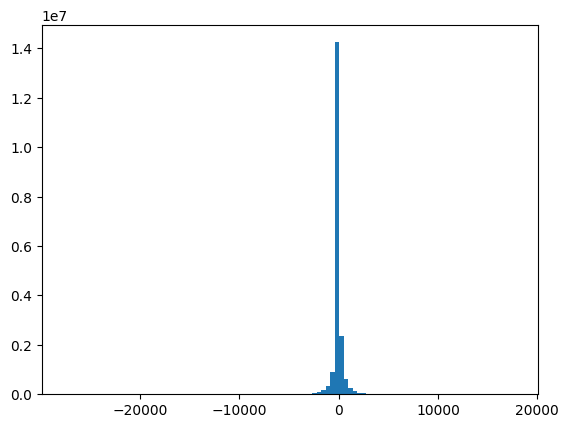

In [400]:
with torch.device("cuda"):
    #########FP
    ln_in_mean = ln_in.mean(dim=-1, keepdim=True)
    ln_in_var = ln_in.var(dim=-1, keepdim=True, unbiased=False)
    dja = ((ln_in-ln_in_mean)/torch.sqrt(ln_in_var+ln_eps)) * ln_weight + ln_bias
    print(dja.min(), dja.max())
    # fig, ax = plt.subplots(1, 4)
    # ax[0].hist(ln_in.flatten().cpu().numpy(), bins=100)
    # ax[1].hist(ln_in_mean.flatten().cpu().numpy(), bins=100)
    # ax[2].hist(ln_in_var.flatten().cpu().numpy(), bins=100)
    # ax[3].hist(dja.flatten().cpu().numpy(), bins=100)
    # plt.show()

    #######################INT
    bits = 16
    scaler = (ln_in.max()-ln_in.min())/(2**bits-1-1)

    dja_q = (ln_in / scaler).round()
    dja_q, s_x = int_LayerNorm(dja_q, scaler, ln_weight, ln_bias, ln_eps)
    dja_fp = dja_q * scaler
    # ln_in_q = torch.clip((ln_in / scaler).round(), -2**(bits-1), 2**(bits-1)-1)
    # ln_in_mean_q = ln_in_q.mean(dim=-1, keepdim=True).round()
    # ln_in_var_q = ln_in_q.var(dim=-1, keepdim=True, unbiased=False).round()

    # ln_weight_q = torch.clip((ln_weight / scaler).round(), -2**(bits-1), 2**(bits-1)-1)
    # ln_bias_q = torch.clip((ln_bias / scaler).round(), -2**(bits-1), 2**(bits-1)-1)
    # ln_eps_q = torch.clip((ln_eps / scaler).round(), -2**(bits-1), 2**(bits-1)-1)

    # var_q = apply_int_SQRT_to_tensor(ln_in_var_q + ln_eps_q)

    # dja_q = (ln_in_q - ln_in_mean_q) / (var_q) * ln_weight_q + ln_bias_q
    # dja_fp = dja_q * scaler

    print(dja_fp.min(), dja_fp.max())
    # fig, ax = plt.subplots(1, 4)
    # ax[0].hist(ln_in_q.flatten().cpu().numpy(), bins=100)
    # ax[1].hist(ln_in_mean_q.flatten().cpu().numpy(), bins=100)
    # ax[2].hist(ln_in_var_q.flatten().cpu().numpy(), bins=100)
    # ax[3].hist(dja_q.flatten().cpu().numpy(), bins=100)
    # plt.show()

    print(torch.norm(dja - dja_fp))

plt.hist(ln_out.flatten().cpu().numpy(), bins=100)
plt.show()
plt.hist(dja.flatten().cpu().numpy(), bins=100)
plt.show()
plt.hist(dja_q.flatten().cpu().numpy(), bins=100)
plt.show()